In [1]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.filter import matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
import numpy as np
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
import pandas as pd
from pycbc.filter import sigma
import h5py
from pycbc.types import timeseries
from pycbc.types import TimeSeries
import pylab as plt

In [2]:
%matplotlib inline

In [48]:
def psd_data(conditioned):

    from pycbc.psd import interpolate, inverse_spectrum_truncation
    # Estimate the power spectral density

    # We use 4 second samples of our time series in Welch method.
    psd = conditioned.psd(4)

    # Now that we have the psd we need to interpolate it to match our data
    # and then limit the filter length of 1 / PSD. After this, we can
    # directly use this PSD to filter the data in a controlled manner

    psd = interpolate(psd, conditioned.delta_f)

    # 1/PSD will now act as a filter with an effective length of 4 seconds
    # Since the data has been highpassed above 30 Hz, and will have low values
    # below this we need to informat the function to not include frequencies
    # below this frequency. 
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=30)

#     pp.loglog(psd.sample_frequencies, psd)
#     pp.ylabel('$Strain^2 / Hz$')
#     pp.xlabel('Frequency (Hz)')
#     pp.xlim(30, 1024)
    
    return psd

In [49]:
def gen_SNR(template,conditioned,psd):
    

    snr = matched_filter(template, conditioned,
                         psd=psd, low_frequency_cutoff=30)

    # The `matched_filter` function actually returns a 'complex' SNR.
    # What that means is that the real portion correponds to the SNR
    # associated with directly filtering the template with the data.
    # The imaginary portion corresponds to filtering with a template that
    # is 90 degrees out of phase. Since the phase of a signal may be 
    # anything, we choose to maximize over the phase of the signal.

    peak = abs(snr).numpy().argmax()
    snrp = abs(snr[peak])
    snrp_compl = snr[peak]
    time = snr.sample_times[peak]

    return snr,time,peak,snrp,snrp_compl

In [50]:
def gen_chisquare(temp,data,m_1,m_2,s_1,s_2,psd):

    n =int(0.72*pycbc.pnutils.get_freq('fSEOBNRv4Peak',m_1,m_2,s_1,s_2)**0.7)

    chisq = power_chisq(temp, data, n, psd=psd, low_frequency_cutoff=30.0)

    # convert to a reduced chisq
    chisq /= (n * 2) - 2

    return chisq

In [51]:
import os

In [52]:
def snr_chisq_nsnr(num_templates,data_templates,psd,data,s):

    template_info = []

    for i in range(num_templates):
        T1 = data_templates[i]

        S1,time_peak,index_peak_bns,old_snr_bns,snrp_compl = gen_SNR(T1,data,psd)
        if not os.path.exists(f"Signals_BBH_BNS/snr_complete_series/snr{i}.hdf"): 
            S1.save(f"Signals_BBH_BNS/snr_complete_series/snr{i}.hdf")

        chisq_1 = gen_chisquare(T1,data,temp_bank[i][0],temp_bank[i][1],s,s,psd)
        chisq_val_bns = chisq_1[index_peak_bns]

        new_snr_bns = newsnr(abs(S1),chisq_1)
        snrp_bns = new_snr_bns[index_peak_bns]

        template_info.append([temp_bank[i][0],temp_bank[i][1],time_peak,old_snr_bns,snrp_bns,chisq_val_bns,i,snrp_compl])

    return template_info

In [59]:
def recovery(data,n,data_templates,psd): 

    full__info =  snr_chisq_nsnr(n,data_templates,psd,data,0.)

    info = {}
    for i in  full__info:
        print(i)
        info.update({i[4] : [i[0],i[1],i[2],i[3],i[5],i[6],i[7]]})

    snrp_1 = max(info.keys())
    time_1 = info.get(max(info.keys()))[2]
    m1_1 = info.get(max(info.keys()))[0]
    m2_1 = info.get(max(info.keys()))[1]
    chi_sq_1 = info.get(max(info.keys()))[4]
    index = info.get(max(info.keys()))[5]
    snrp_compl = info.get(max(info.keys()))[6]

    print("The signal detected is due to the following masses ",m1_1,"M and ", m2_1, "M at time ", time_1, "seconds", " with new SNR value as", snrp_1, " and chi~square value as ", chi_sq_1,"at index",index)

    return m1_1,m2_1,time_1,snrp_1,full__info,index,snrp_compl

In [74]:
def aligned_template(mass_1, mass_2, time, snrp_compl, ts1):
    dt = time - ts1.start_time
    temp_sub  = gen_template('IMRPhenomPv2', mass_1, mass_2, 0., 0., ts1)

    aligned = temp_sub.cyclic_time_shift(dt)

    aligned = (aligned.to_frequencyseries() * snrp_compl).to_timeseries() / abs(snrp_compl)
    aligned.start_time = ts1.start_time

    return aligned

In [84]:
def find_bns(index, mass_1, mass_2, time, snrp_compl, ts1):

    T_B1 = data_templates[index]
    T_B1_MF = timeseries.load_timeseries(f"Signals_BBH_BNS/snr_complete_series/snr{index}.hdf")

    A = []
    B = []
    maxim_SNR = []
    
    aligned_temp = aligned_template(mass_1, mass_2, time, snrp_compl, ts1)

    for i in range(40):
        if i != index:
            cross = matched_filter(aligned_temp, data_templates[i],
                             psd=psd1, low_frequency_cutoff=30)

            T_N1_MF = timeseries.load_timeseries(f"Signals_BBH_BNS/snr_complete_series/snr{i}.hdf")

            A_B1 = (T_B1_MF - (cross*T_N1_MF))/(1-(cross**2))
            A.append(A_B1)

            A_N1 = (T_N1_MF - (cross*T_B1_MF))/(1-(cross**2))
            B.append(A_N1) 

            norm = (A_B1**2) + (A_N1**2) + 2*(A_B1*A_N1*cross)

            SNR = ((A_B1*T_B1_MF) + ( A_N1 * T_N1_MF))/norm

            peak_SNR = abs(SNR).numpy().argmax()

            SNR_p = abs(SNR[peak_SNR])

            maxim_SNR.append([i,SNR_p,T_N1_MF[peak_SNR]])

    M_SNR = 0
    idx = 0
    cSNR = 0

    for i in range(len(maxim_SNR)):
        if M_SNR < maxim_SNR[i][1]:
            M_SNR = maxim_SNR[i][1]
            idx = maxim_SNR[i][0]
            cSNR = maxim_SNR[i][2]

    return idx, M_SNR, temp_bank[idx][0], temp_bank[idx][1], SNR.sample_times[idx], cSNR

In [85]:
def find_bbh(index, mass_1, mass_2, time, snrp_compl, ts1):

    T_N1 = data_templates[index]
    T_N1_MF = timeseries.load_timeseries(f"Signals_BBH_BNS/snr_complete_series/snr{index}.hdf")

    A = []
    B = []
    maxim_SNR = []
    
    aligned_temp = aligned_template(mass_1, mass_2, time, snrp_compl, ts1)

    for i in range(40):
        if i != index:
            cross = matched_filter(aligned_temp, data_templates[i],
                             psd=psd1, low_frequency_cutoff=30)

            T_B1_MF = timeseries.load_timeseries(f"Signals_BBH_BNS/snr_complete_series/snr{i}.hdf")

            A_B1 = (T_B1_MF - (cross*T_N1_MF))/(1-(cross**2))
            A.append( A_B1 )

            A_N1 = (T_N1_MF - (cross*T_B1_MF))/(1-(cross**2))
            B.append(A_N1) 

            norm = (A_B1**2) + (A_N1**2) + 2*(A_B1*A_N1*cross)

            SNR = ((A_B1*T_B1_MF) + ( A_N1 * T_N1_MF))/norm

            peak_SNR = abs(SNR).numpy().argmax()

            SNR_p = abs(SNR[peak_SNR])

            maxim_SNR.append([i,SNR_p,T_B1_MF[peak_SNR]])

    M_SNR = 0
    idx = 0
    cSNR = 0

    for i in range(len(maxim_SNR)):
        if M_SNR < maxim_SNR[i][1]:
            M_SNR = maxim_SNR[i][1]
            idx = maxim_SNR[i][0]
            cSNR = maxim_SNR[i][2]

    return idx, M_SNR, temp_bank[idx][0], temp_bank[idx][1], SNR.sample_times[idx], cSNR

In [57]:
data_templates = []

for i in range(20):
    T = timeseries.load_timeseries(f"Signals_BBH_BNS/signal_bbh{i}.hdf")
    data_templates.append(T)
for i in range(20):
    R = timeseries.load_timeseries(f"Signals_BBH_BNS/signal_bns{i}.hdf")
    data_templates.append(R)
    
temp_bank = pd.read_csv('Signals_BBH_BNS/Load_bbh_bns.csv')
temp_bank = temp_bank.values.tolist()

In [87]:
for j in range(1):

    print("Recovery number:",j)
    print(' ')

    # ts1 = timeseries.load_timeseries(f"Signals_BBH_BNS/Data_{j}.hdf")
    psd1 = psd_data(ts1)
    mass_1,mass_2,time,snrp,total,index,snrp_compl = recovery(ts1,20,data_templates,psd1)

    print(' ')

Recovery number: 0
 
[25.3124840736438, 25.767297894745493, 99.815673828125, 273.60364011902243, 9.2224413207247, 1108.907377165605, 0, (-82.28428811689184+260.9372488079766j)]
[19.66472776115617, 28.829538590310523, 99.82470703125, 228.69311854930618, 7.311330318721331, 1232.6980659710478, 1, (-122.75746983336815-192.9537407564744j)]
[27.9260013682452, 28.42240443219461, 99.806884765625, 278.470200972511, 8.792975430208994, 1263.6565972479334, 2, (137.21480926255322+242.3174548989647j)]
[27.191392084477236, 27.980437348212533, 99.807373046875, 281.24405259623416, 9.002068017954624, 1229.7743946030832, 3, (-92.75560795756877+265.5082189183136j)]
[26.58109028449369, 33.05341387654879, 99.80615234375, 279.9335232856815, 8.095672920132415, 1506.4240663480477, 4, (279.4862575760245+15.818005098091753j)]
[11.66828398486552, 35.14524881998979, 99.86474609375, 117.97886844624666, 3.6636057077615303, 1306.5749599546177, 5, (54.30349017968389-104.7384569017596j)]
[20.938949466673236, 30.5800045

In [ ]:
index = 6
for i in range(10):
    ibns, snrp_bns, mass_1, mass_2, time, snrp_compl = find_bns(index, mass_1, mass_2, time, snrp_compl, ts1)
    ibbh, snrp_bbh, mass_1, mass_2, time, snrp_compl = find_bbh(ibns, mass_1, mass_2, time, snrp_compl, ts1)
    print(temp_bank[ibns], snrp_bns, temp_bank[ibbh], snrp_bbh)
    index = ibbh

In [90]:
mass_1,mass_2,time,snrp,index,snrp_compl

(20.938949466673236,
 30.580004573878607,
 99.816162109375,
 9.68760458954083,
 6,
 (-58.743892869831534-271.59334124789854j))

---

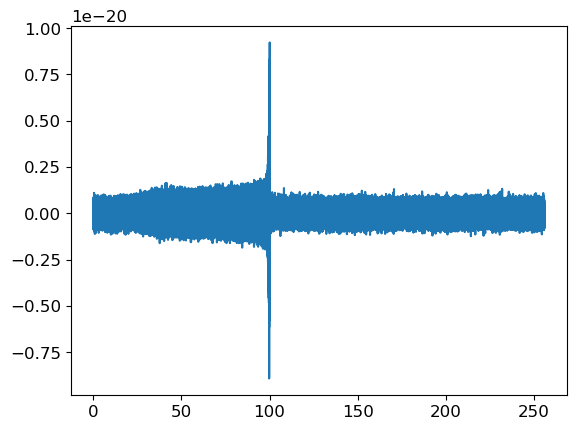

In [66]:
ts1.plot()

In [91]:
T_B1 = data_templates[index]
T_B1_MF = timeseries.load_timeseries(f"Signals_BBH_BNS/snr_complete_series/snr{index}.hdf")

A = []
B = []
maxim_SNR = []

aligned_temp = aligned_template(mass_1, mass_2, time, snrp_compl, ts1)

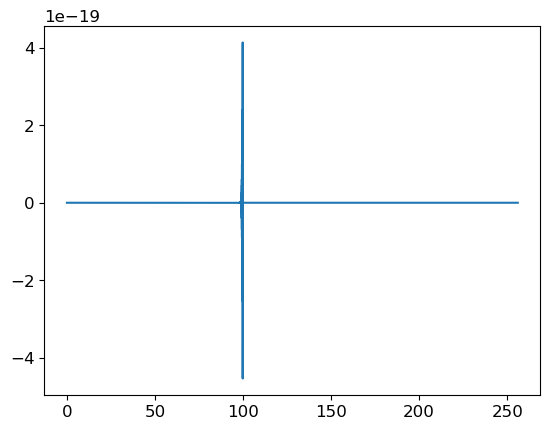

In [92]:
aligned_temp.plot()

In [96]:
i = 0
cross = matched_filter(data_templates[i], aligned_temp,
                 psd=psd1, low_frequency_cutoff=30)

([<matplotlib.lines.Line2D at 0x7fdb4f98a450>],
 [<matplotlib.lines.Line2D at 0x7fdb4f98a750>])

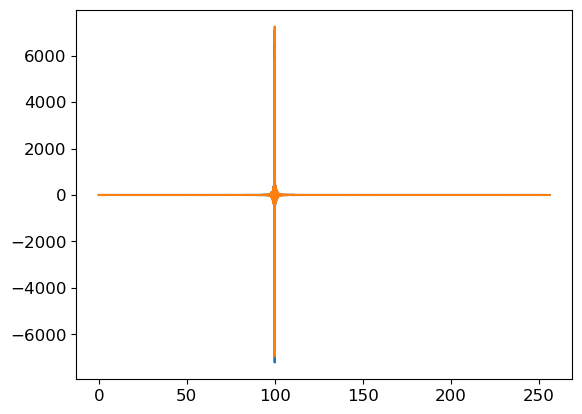

In [97]:
cross.plot()

In [98]:
T_N1_MF = timeseries.load_timeseries(f"Signals_BBH_BNS/snr_complete_series/snr{i}.hdf")

In [ ]:
A_B1 = (T_B1_MF - (cross*T_N1_MF))/(1-(cross**2))
A.append(A_B1)

A_N1 = (T_N1_MF - (cross*T_B1_MF))/(1-(cross**2))
B.append(A_N1) 

norm = (A_B1**2) + (A_N1**2) + 2*(A_B1*A_N1*cross)

SNR = ((A_B1*T_B1_MF) + ( A_N1 * T_N1_MF))/norm

peak_SNR = abs(SNR).numpy().argmax()

SNR_p = abs(SNR[peak_SNR])

maxim_SNR.append([i,SNR_p,T_N1_MF[peak_SNR]])

M_SNR = 0
idx = 0
cSNR = 0

for i in range(len(maxim_SNR)):
    if M_SNR < maxim_SNR[i][1]:
        M_SNR = maxim_SNR[i][1]
        idx = maxim_SNR[i][0]
        cSNR = maxim_SNR[i][2]

In [67]:
snrp_compl,time,mass_1,mass_2

((-58.743892869831534-271.59334124789854j),
 99.816162109375,
 20.938949466673236,
 30.580004573878607)

In [30]:
cross1 = matched_filter(data_templates[1], data_templates[21],
                             psd=psd1, low_frequency_cutoff=30)

cross2 = matched_filter(data_templates[21], data_templates[1],
                             psd=psd1, low_frequency_cutoff=30)

In [69]:
def gen_template(model,m1,m2,s1z,s2z,conditioned):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    
    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    time=0.0



    # We can calcualate the antenna pattern for Hanford at
    # the specific sky location
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    
    
    
    
    hp, hc = get_td_waveform(approximant=model,
                     mass1=m1,
                     mass2=m2,spin1z=s1z,spin2z=s2z,
                     delta_t=conditioned.delta_t,
                     f_lower=30)
    
    
    ht_template = fp * hp + fc * hc
    
    #Resizing the template to match data
    ht_template.resize(len(conditioned))
    
    #Time shift 
    template = ht_template.cyclic_time_shift(ht_template.start_time)
    
   
    return template


In [39]:
def gen_waveform(model,m1,m2,s1z,s2z,distance,time,l):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    hp_1, hc_1 = get_td_waveform(approximant=model,
                             mass1=m1, mass2=m2,spin1z=s1z,spin2z=s2z,
                             distance=distance, inclination=inclination_1,
                             delta_t=1.0/4096, f_lower=30)

    ht_1 = fp * hp_1 + fc * hc_1

    return ht_1

In [40]:
def overlap(ht_1,ht_2,buffer):

    if len(ht_1) < len(ht_2):
        ht_small, ht_big = ht_1, ht_2
    else:
        ht_small, ht_big = ht_2, ht_1

    dt = ht_small.delta_t

    # make buffer int multiple of dt
    buffer = np.round(buffer*ht_big.sample_rate)/ht_big.sample_rate
    # elongate the long template to accomodate enough space on left
    ht_big.resize(len(ht_big)+int(buffer*ht_big.sample_rate))
    # match small template
    ht_small.resize(len(ht_big))
    # correct the position after resizing
    ht_big = ht_big.cyclic_time_shift(buffer)
    #Shifting the merger time
    ht_small = ht_small.cyclic_time_shift(ht_small.start_time-ht_big.start_time-buffer)
    #Equating the start time of both signals
    ht_small.start_time = ht_big.start_time
    # resample to original sample rate
    ht_big = ht_big.resample(dt)
    ht_small = ht_small.resample(dt)

    #Combining the signals
    ht_total = ht_small + ht_big

    return ht_total,ht_2

In [41]:
def gen_noise(psd_need):

    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    # Generate 256 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(256/ delta_t)
    ts = pycbc.noise.gaussian.noise_from_psd(tsamples,delta_t, psd, seed=127)

    return ts

In [45]:
def inject(ht_total,ts,injtime):

    # append extra zeros than required
    ht_total.append_zeros(int((ts.duration-injtime)*1.2*4096))

    ht_total = ht_total.cyclic_time_shift(int(injtime + ht_total.start_time))
    ht_total = ht_total.resample(ts.delta_t)

    #Resizing the signal
    ht_total.resize(len(ts))

    #Equating the start time
    ht_total.start_time = ts.start_time

    #Injecting signal into noise
    ts = ts.add_into(ht_total)

    #plotting the result
    pp.plot(ts.sample_times, ts)
    pp.xlabel('Time(s)')
    pp.ylabel('Strain')
    pp.grid()
    pp.show()

    return ts

In [62]:
i1 = 13
i2 = 31
m1_1 = temp_bank[i1][0]
m2_1 = temp_bank[i1][1]
m1_2 = temp_bank[i2][0]
m2_2 = temp_bank[i2][1]
buffer = 0.3
noise = gen_noise(False)

print(f'BBH: ({m1_1}, {m2_1}), BNS: ({m1_2}, {m2_2})')

BBH: (13.751641815788702, 31.056557369267846), BNS: (1.352146060337832, 1.2530419301828557)


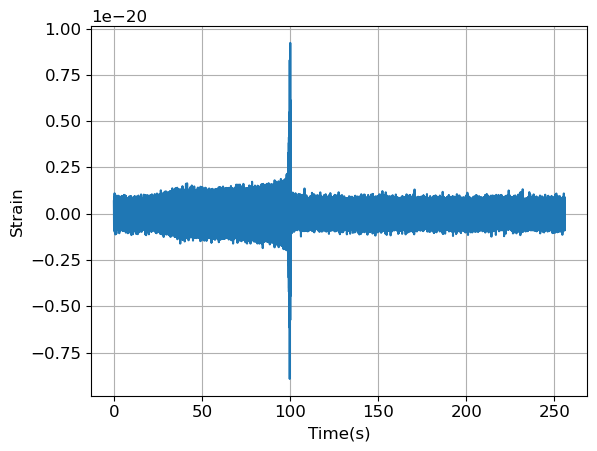

In [63]:
h1_bbh = gen_waveform('IMRPhenomPv2', m1_1, m2_1, 0., 0., 50, 0., "BBH")
h1_bns = gen_waveform('TaylorF2', m1_2, m2_2, 0., 0., 2, 0., "BNS")

ht_total,h1_bbh = overlap(h1_bbh,h1_bns,buffer)
ts1 = inject(ht_total,noise,100)